# Analyzing US Census Data for HigherME
**Nava Roohi ,Cole Bailey, Filipp Krasovsky**

In [1]:
import pandas as pd 
import degree_codes as dc
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
import warnings
warnings.filterwarnings("ignore")

In [326]:
df = pd.read_csv("df_stratified_2.csv")
df.head()

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,...,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,EMPSTATD,OCC,IND,INCWAGE
0,2020,2016,202003,6676264,2016000978820,5.15,2020066762643,55,10055,1,...,65,0,0,0,0,1,10,5510,6380,51776
1,2020,2016,202003,4027595,2016000661290,17.51,2020040275953,36,60036,1,...,64,0,0,0,0,1,10,8990,770,21573
2,2020,2017,202003,5156019,2017000181278,6.18,2020051560193,42,370142,1,...,101,53,5301,0,0,3,30,2310,7860,0
3,2020,2020,202003,6777997,2020000352838,69.01,2020067779973,55,5510155,1,...,63,0,0,0,0,1,10,910,6870,52000
4,2020,2017,202003,4717146,2017000352033,15.45,2020047171463,39,280039,1,...,63,0,0,0,0,1,10,4220,7870,40126


In [327]:
#sanity check to make sure our age is above 18
df['AGE'].min()

18

## Data Cleaning

#### Step 1. State Extraction from FIP Numbers
We can use the degree_codes package we imported earlier to get a list of all state FIPs.

In [328]:
#map to a new variable called "State"
df['State'] = df['STATEFIP'].apply(lambda x: dc.fips[x])
df.head()

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,...,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,EMPSTATD,OCC,IND,INCWAGE,State
0,2020,2016,202003,6676264,2016000978820,5.15,2020066762643,55,10055,1,...,0,0,0,0,1,10,5510,6380,51776,Wisconsin
1,2020,2016,202003,4027595,2016000661290,17.51,2020040275953,36,60036,1,...,0,0,0,0,1,10,8990,770,21573,New York
2,2020,2017,202003,5156019,2017000181278,6.18,2020051560193,42,370142,1,...,53,5301,0,0,3,30,2310,7860,0,Pennsylvania
3,2020,2020,202003,6777997,2020000352838,69.01,2020067779973,55,5510155,1,...,0,0,0,0,1,10,910,6870,52000,Wisconsin
4,2020,2017,202003,4717146,2017000352033,15.45,2020047171463,39,280039,1,...,0,0,0,0,1,10,4220,7870,40126,Ohio


### Step 2. Breakdown by Race, Initial EDA 

In [329]:
race_map ={
    1: "White"
    ,2: "Black/African American"
    ,3: "American Indian or Alaska Native"
    ,4: "Chinese"
    ,5: "Japanese"
    ,6: "Other Asian or Pacific Islander"
    ,7: "Other race, nec"
    ,8: "Two major races"
    ,9: "Three or more major races"
}
df['RACE'].apply(lambda x: race_map[x]).value_counts()

White                               149702
Black/African American               18795
Other Asian or Pacific Islander       7644
Other race, nec                       7137
Two major races                       5731
Chinese                               2824
American Indian or Alaska Native      1999
Three or more major races              598
Japanese                               569
Name: RACE, dtype: int64

Based on the definition, however, we are primarily interested in exploring career differences between non-white/asian individuals and their counterparts based on documentation that can be accessed <a href="https://github.com/kayfilipp/HigherME/blob/main/README.md">here</a>. To this end, we can re-map the race for each row to exclude indices 1, 4, and 5. We do not exclude pacific islanders as of now, but are open to doing so if requirements change. We also include any hispanic individuals in our definition of under represented.

In [330]:
non_target = [1,4,5]
def under_rep_id(race,hispan):
    #if target is not 'Non-Hispanic'...
    if hispan != 0:
        return 1
    #and target isn't nonwhite/ nonasian...
    if race not in non_target:
        return 1
    #then they're not under-represented.
    return 0

df['under_represented'] = df.apply(lambda x: under_rep_id(x.RACE,x.HISPAN),axis=1)
df[['RACE','under_represented']].sample(10)

,RACE,under_represented
185337,8,1
143088,1,0
189234,4,0
151254,2,1
96067,1,0
81741,1,0
149330,1,1
119694,1,0
28948,1,0
56656,1,0


<AxesSubplot:title={'center':'Under represented presence in dataset'}>

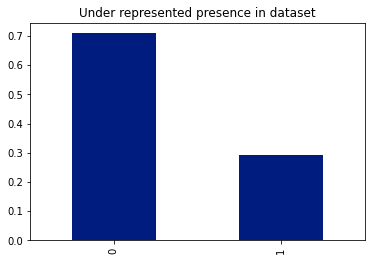

In [331]:
df['under_represented'].value_counts(normalize=True).plot(kind='bar',title='Under represented presence in dataset')

#### Since we're not doing low level analysis that explores the differences between Black and Hispanic applicants, we can drop the nuance on hispanic data for now.

In [332]:
df = df.drop(['HISPAN','HISPAND'],axis=1)

### Step 3. Breakdown by Birthplace, EDA

#### Furthermore, we can divide the birthplace feature (BPL) into a more low-resolution field - foreign born and domestic born individuals (ie those who are born in the continental US):

In [333]:
def is_domestic(bpl):
    #if birthplace code is for the US...
    if bpl < 100:
        return 1
    return 0

df['domestic_born'] = df['BPL'].map(is_domestic)
df[['BPL','domestic_born']].head()

,BPL,domestic_born
0,27,1
1,36,1
2,200,0
3,27,1
4,39,1


Putting all this together, we can conclude that individuals that are born abroad and move to the US tend to be under-represented, while, as intiuition dictates, individuals born in the US tend to not be underrepresented. 

<AxesSubplot:title={'center':'Distribution of Underrepresented persons by birthplace'}, xlabel='domestic_born'>

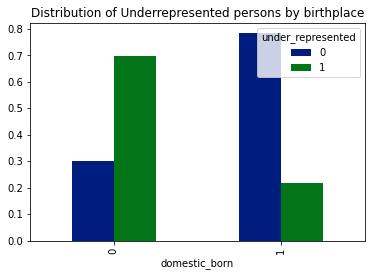

In [334]:
pd.crosstab(
    df['domestic_born'],
    df['under_represented'],
    normalize='index'
).plot.bar(
    title='Distribution of Underrepresented persons by birthplace'
)

### Step 4. Educational Attainment, EDA

**Context:** The ``EDUC`` field contains values from 0-11 representing levels of educational attainment in increasing order - that is, a 0 is lower than a 1, etc. The `EDUCD` field extrapolates on the low-level details in a similar fashion. Our primary motivation is to simplify these values broadly into the following categories:

<ul>
    <li>None/Below Secondary (High School)</li>
    <li>Secondary (High School)</li>
    <li>Associate's</li>
    <li>Bachelor's</li>
    <li>Master's</li>
    <li>PhD/Other</li>
</ul>

In [335]:
df['EDUC'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11], dtype=int64)

In [336]:
df['EDUCD'].sort_values().unique()

array([  2,  11,  12,  14,  15,  16,  17,  22,  23,  25,  26,  30,  40,
        50,  61,  63,  64,  65,  71,  81, 101, 114, 115, 116], dtype=int64)

In [337]:
def highest_edu(educd):
    if educd in [81,82,83]:
        return 'Associate'
    if educd == 101:
        return 'Bachelor'
    if educd in [114,115]:
        return 'Master'
    if educd in [116]:
        return 'PhD'
    if educd < 62 or educd==999:
        return 'None/Below HS'
    if educd < 114:
        return 'High School'
    
df['EDU_verbose'] = df['EDUCD'].map(highest_edu)
df[['EDU_verbose','EDUCD']].tail()

,EDU_verbose,EDUCD
194994,Bachelor,101
194995,Master,114
194996,High School,71
194997,High School,71
194998,Bachelor,101


<AxesSubplot:title={'center':'Distribution of Underrepresented persons by degree attainment'}, xlabel='under_represented'>

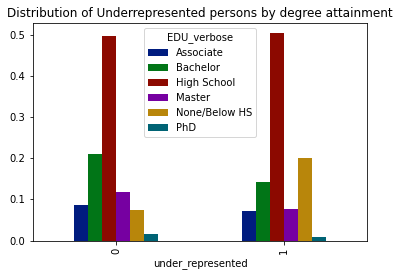

In [338]:
pd.crosstab(
    df['under_represented'],
    df['EDU_verbose'],
    normalize='index'
).plot.bar(
    title='Distribution of Underrepresented persons by degree attainment'
)

major takeaways here include the fact that under-represented persons tend to drop out of high school at a far greater rate while earning fewer high school diplomas, master's degrees, associate's degrees, and bachelor's degrees.

### Employment & Education, EDA

we first observe the difference in employment status across represented and underepresented groups and find that most of the populartion is employed in both groups, but under-represented communities tend to be more unemployed.

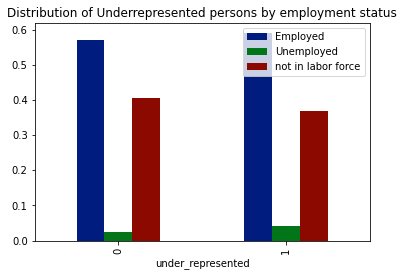

In [339]:
pd.crosstab(
    df['under_represented'],
    df['EMPSTAT'],
    normalize='index'
).plot.bar(
    title='Distribution of Underrepresented persons by employment status'
)
plt.legend(['Employed','Unemployed','not in labor force'])

#### Analyzing STEM Education in Particular
In order to identify if a degree belong to a stem field, we have two tiers of analysis - one at the `DEGFIELD` level, which shows us a high-level description of the degree in question. If we do not confirm at this level that a field of study is STEM, we move into the `DEGFIELDD` field, which offers more specific information on the degree.

**for this section, we have developed a separate library containing logic that separates both DEGFIELD and DEGFIELDD codes into stem designation.**

In [340]:
df['is_STEM'] = df.apply(lambda x: dc.is_stem_degree(x.DEGFIELD,x.DEGFIELDD),axis=1)

In [341]:
df[['DEGFIELD','DEGFIELDD','is_STEM']].head()

,DEGFIELD,DEGFIELDD,is_STEM
0,0,0,0
1,0,0,0
2,53,5301,0
3,0,0,0
4,0,0,0


#### STEM Degree Attainment by Target Variable
A cursory analysis suggests that underrepresented individuals in STEM majors tend to have a significantly lower presence than in non-STEM fields.

<AxesSubplot:title={'center':'Distribution of Underrepresented persons by STEM attainment'}, xlabel='is_STEM'>

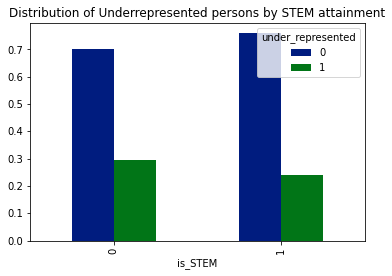

In [342]:
pd.crosstab(
    df['is_STEM'],
    df['under_represented'],
    normalize='index'
).plot.bar(
    title='Distribution of Underrepresented persons by STEM attainment'
)

#### Which STEM majors have the smallest under-represented group?

Preliminary findings suggest that under-represented groups are least present in military technologies, Environmental Sciences, Math, and Physical Sciences.

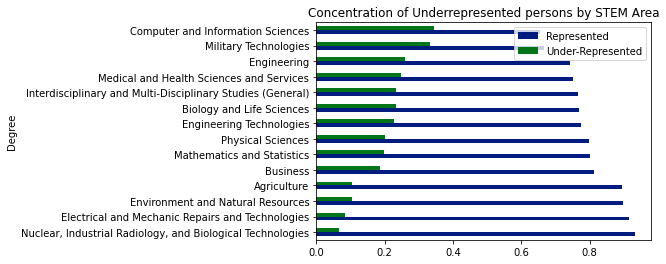

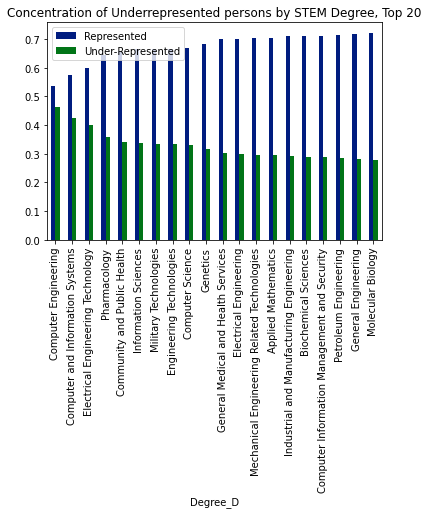

In [343]:
df['Degree'] = df['DEGFIELD'].apply(lambda x: dc.degree_codes[x])
df['Degree_D']=df['DEGFIELDD'].apply(lambda x: dc.detail_codes[x])
temp = df.query("is_STEM==1")

pd.crosstab(
    temp['Degree'],
    temp['under_represented'],
    normalize='index'
).sort_values(1).plot.barh(
    title='Concentration of Underrepresented persons by STEM Area'
)
plt.legend(['Represented','Under-Represented'])

pd.crosstab(
    temp['Degree_D'],
    temp['under_represented'],
    normalize='index'
).sort_values(0)[:20].plot.bar(
    title='Concentration of Underrepresented persons by STEM Degree, Top 20'
)
plt.legend(['Represented','Under-Represented'])
del temp

However, we also note considerably racial parity in Computer Engineering, Electrical Engineering Technology and Computer Engineering - beyond these, in sorter order, racial parity begins to decrease quickly.

### Analyzing Career Attainment by Race, EDA

we begin by loading in a mapping from the IPUMS Census Occupation Codes data to give us a better interpretation of the `OCC` field in our dataset, which can be found <a href='https://usa.ipums.org/usa/volii/occ2018.shtml'>here</a>.

In [344]:
import re
occupations = pd.read_csv('occupation_map.csv')

#standardize to lowercase
def stdize(occ):
    out = occ.lower()
    out = re.sub("[^a-z\s]","",out)
    return out 
occupations['Occupation'] = occupations['Occupation'].map(stdize)

occupations = dict(zip(occupations.OCC, occupations.Occupation))
#get a sample 
list(occupations.values())[:5]

['na not applicable',
 'chief executives and legislators',
 'general and operations managers',
 'advertising and promotions managers',
 'marketing managers']

Next, we can use an apply function to determine everyone's occupation:

In [345]:
pd.set_option('display.max_colwidth', None)  
df['JobRole'] = df['OCC'].apply(lambda x: occupations[x])
df[['OCC','JobRole']].head()

,OCC,JobRole
0,5510,couriers and messengers
1,8990,miscellaneous production workers including equipment operators and tenders
2,2310,elementary and middle school teachers
3,910,credit counselors and loan officers
4,4220,janitors and building cleaners


#### What Roles do STEM majors tend to go into? 
We omit any indivudals with an `EmpStatus` that isn't 1 to get a clearer insight on employed STEM individuals.

<AxesSubplot:title={'center':'Top 20 Occupations for STEM majors'}>

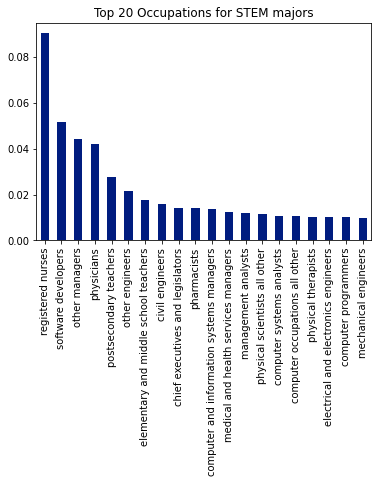

In [346]:
temp = df.query("is_STEM==1 & EMPSTAT==1")
(temp['JobRole'].value_counts(normalize=True).sort_values(
    ascending=False
)[0:20]).plot(kind='bar',title='Top 20 Occupations for STEM majors')

#### What roles do under-represented STEM majors go into compared to their counterparts?

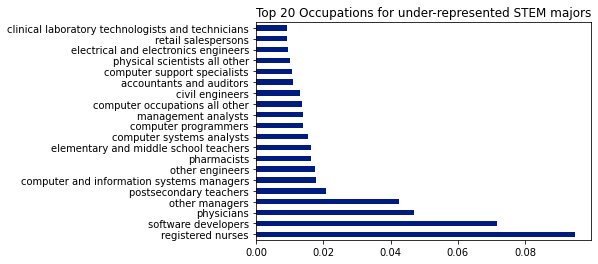

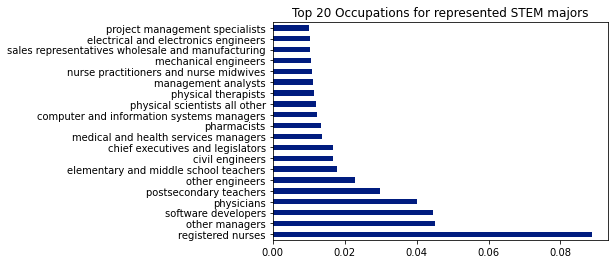

In [347]:
df.query("is_STEM==1 & EMPSTAT==1 & under_represented==1")['JobRole']\
 .value_counts(normalize=True).sort_values(
    ascending=False
)[0:20]\
.plot(kind='barh',title='Top 20 Occupations for under-represented STEM majors')
plt.show()

df.query("is_STEM==1 & EMPSTAT==1 & under_represented==0")['JobRole']\
 .value_counts(normalize=True).sort_values(
    ascending=False
)[0:20]\
.plot(kind='barh',title='Top 20 Occupations for represented STEM majors')
plt.show()

We can see that many STEM majors tend to go into nursing, leadership roles, but primarily into analyst and engineering roles, which lines up with expectations. Next, we can explore this breakdown by racial representation:

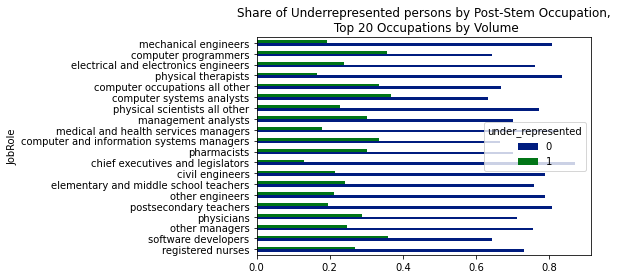

In [348]:
job_by_rep = pd.crosstab(
    temp['JobRole']
    ,temp['under_represented']
)

#add another column for total employment and sort to get top 20 roles
job_by_rep[2] = job_by_rep[0]+job_by_rep[1]
job_by_rep[0] = job_by_rep[0] / job_by_rep[2]
job_by_rep[1] = 1 - job_by_rep[0]
job_by_rep    = job_by_rep.sort_values(2,ascending=False)[:20]
#get rid of total field to make chart clearer.
job_by_rep    = job_by_rep.drop(2,axis=1)
ax=job_by_rep.plot.barh(
    title=f'Share of Underrepresented persons by Post-Stem Occupation,\n Top {len(job_by_rep)} Occupations by Volume'
)

### Defining STEM Occupations

We can do this by ingesting a list of STEM occupations from our previous occupation list from <a href="https://www.onetonline.org/find/stem?t=0">O-Net</a> data and using a simple mapping function after we standardize the occupation names.

In [349]:
stem_occupations = pd.read_csv("All_STEM_Occupations.csv").rename({"Occupation Types":"type"},axis=1)
#standardize to lowercase and remove grammar
stem_occupations['Occupation'] = stem_occupations['Occupation'].map(stdize)

Based on stakeholder input, we also conclude that while nurses are listed as a STEM role, we do not consider them for our analysis. We also exclude other peculiarities such as sociologists.

In [350]:
for term in dc.career_blacklist:
    removed = stem_occupations[
        stem_occupations["Occupation"].str.contains(term)==True
    ]['Occupation'].unique()
    #debug
    #print(f"deleting the following terms: {list(removed)}")
    stem_occupations = stem_occupations[stem_occupations["Occupation"].str.contains(term)==False]


In [351]:
#dictionarize
stem_occupations = dict(zip(stem_occupations.Occupation, stem_occupations.type))

#create a function that identifies a job's STEM role type
def stemType(job):
    if job in stem_occupations:
        return stem_occupations[job]
    return -1

df['stemType'] = df['JobRole'].map(stemType)
df[['stemType','JobRole']].head()

,stemType,JobRole
0,-1,couriers and messengers
1,-1,miscellaneous production workers including equipment operators and tenders
2,-1,elementary and middle school teachers
3,-1,credit counselors and loan officers
4,-1,janitors and building cleaners


#### What Portion of people work in a STEM field?

Under-represented groups tend to be slightly less employed in STEM fields, with similar patterns of employment in STEM fields to their counterparts, with R&D, Design, and Practicioner fields taking the bulk of employment.

In [352]:
df.groupby('under_represented')['stemType'].value_counts(normalize=True)

under_represented  stemType                                                                       
0                  -1                                                                                 0.965880
                   Research, Development, Design, and Practitioners                                   0.022551
                   Managerial                                                                         0.004160
                   Technologists and Technicians                                                      0.004015
                   Research, Development, Design, and Practitioners; Technologists and Technicians    0.003162
                   Sales                                                                              0.000232
1                  -1                                                                                 0.971540
                   Research, Development, Design, and Practitioners                                   0.018739
             

this can better be understood by removing absent STEM-types from the chart:

In [353]:
df[df['stemType']!=-1].groupby('under_represented')['stemType'].value_counts(normalize=True)

under_represented  stemType                                                                       
0                  Research, Development, Design, and Practitioners                                   0.660941
                   Managerial                                                                         0.121925
                   Technologists and Technicians                                                      0.117684
                   Research, Development, Design, and Practitioners; Technologists and Technicians    0.092663
                   Sales                                                                              0.006785
1                  Research, Development, Design, and Practitioners                                   0.658416
                   Managerial                                                                         0.119431
                   Technologists and Technicians                                                      0.109530
             

#### What portion of STEM Employees have a post-secondary education?
Results show a slightly larger number of STEM employees with no college education for under-represented groups.

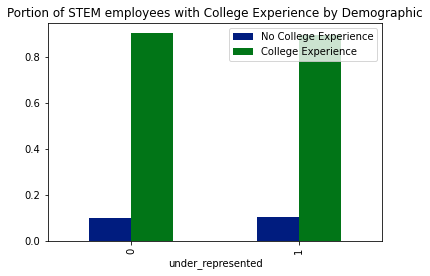

In [354]:
stem_employees = df[df['stemType']!=-1]
stem_employees['past_HS'] = stem_employees['EDUC'] >= 7

pd.crosstab(
    stem_employees['under_represented'],
    stem_employees['past_HS'],
    normalize='index'
).plot(kind='bar',title='Portion of STEM employees with College Experience by Demographic')
plt.legend(['No College Experience','College Experience'])

#### How do rates of college non-completion affect wages in a given profession?

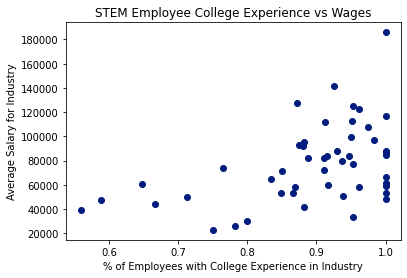

In [355]:
wage_hs = stem_employees.groupby('JobRole')[['INCWAGE','past_HS']].mean()
plt.scatter(x=wage_hs['past_HS'],y=wage_hs['INCWAGE'])
plt.title("STEM Employee College Experience vs Wages")
plt.xlabel("% of Employees with College Experience in Industry")
plt.ylabel("Average Salary for Industry")
plt.show()

#### Breaking Down STEM Role Areas By Demographic

First, we examine what portion of each group is employed in STEM in general, then for individuals who hold a STEM degree. Analysis of the general population shows that across the board, under-represented individuals tend to be employed less frequently in STEM roles than in non-STEM roles.

<AxesSubplot:title={'center':'Concentration of Underrepresented persons by STEM Jobs'}, xlabel='stemType'>

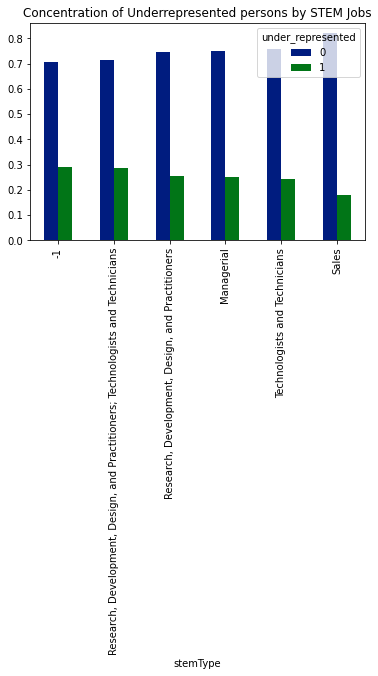

In [356]:
pd.crosstab(
    df['stemType'],
    df['under_represented'],
    normalize='index'
).sort_values(0).plot.bar(
    title='Concentration of Underrepresented persons by STEM Jobs'
)

#### What STEM roles do under-represented STEM graduates take on?

<AxesSubplot:title={'center':'Concentration of Underrepresented STEM Graduates by STEM Job Areas'}>

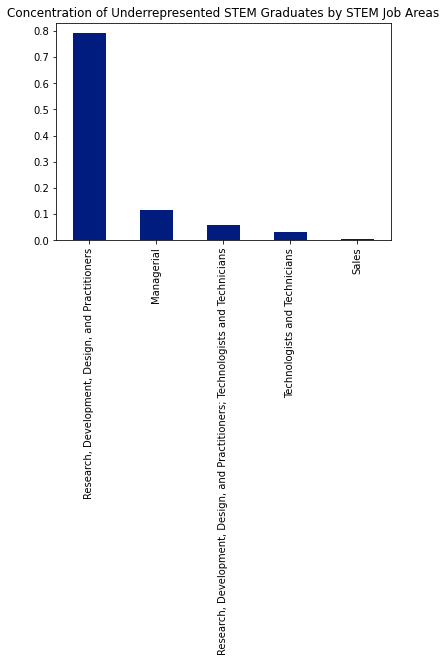

In [357]:
df[df['stemType']!=-1].query("is_STEM==1 & under_represented==1")['stemType'].value_counts(normalize=True).plot(kind='bar',title='Concentration of Underrepresented STEM Graduates by STEM Job Areas')

<AxesSubplot:title={'center':'Concentration of Underrepresented STEM Graduates by STEM Jobs, Top 10'}>

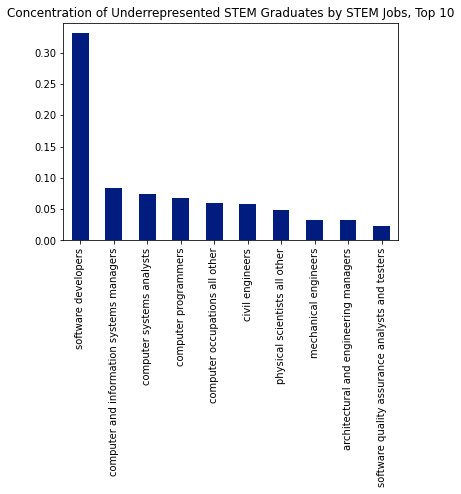

In [358]:
df[df['stemType']!=-1].query("is_STEM==1 & under_represented==1")['JobRole'].value_counts(normalize=True)[0:10].plot(kind='bar',title='Concentration of Underrepresented STEM Graduates by STEM Jobs, Top 10')

STEM Graduates primarily tend to take on nursing and software developer roles - RNs, software evelopers, medical managers, computer occupations, and computer programs - which can all roughly be categorized as either medical or software development roles. 

#### Salary Analysis - How Much Do Stem Employees Earn?

<AxesSubplot:title={'center':'Median Wage by STEM Job Type'}, xlabel='stemType'>

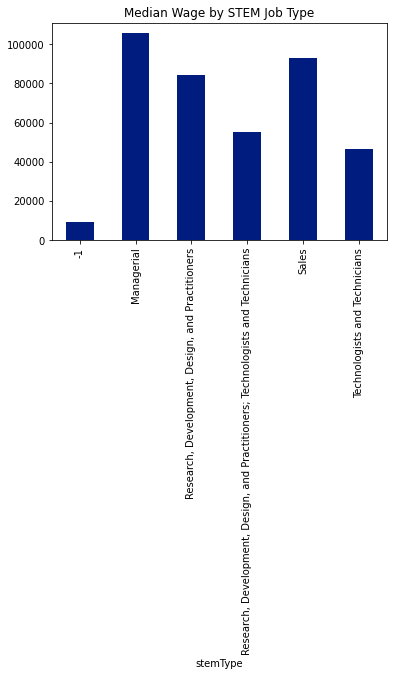

In [359]:
df.groupby('stemType')['INCWAGE'].median().plot(kind='bar',title='Median Wage by STEM Job Type')

In [360]:
df[df['stemType']!=-1].groupby(['under_represented','stemType'])['INCWAGE'].median()

under_represented  stemType                                                                       
0                  Managerial                                                                         105596.0
                   Research, Development, Design, and Practitioners                                    85000.0
                   Research, Development, Design, and Practitioners; Technologists and Technicians     55665.0
                   Sales                                                                               96387.0
                   Technologists and Technicians                                                       46922.0
1                  Managerial                                                                         105596.0
                   Research, Development, Design, and Practitioners                                    84476.0
                   Research, Development, Design, and Practitioners; Technologists and Technicians     53933.0
             

Underrepresented employees make considerably less in managerial and R&D/Practicioner roles than their counterparts. We can also extend this analysis to specific jobs, looking at the top 20 fields:

In [361]:
#get top 20 fields by volume of employees
top_twenty_fields = df[df['stemType']!=-1]['JobRole'].value_counts().sort_values(ascending=False)[:20]
top_twenty_fields = list(top_twenty_fields.index)
top_twenty_fields[:5]

['software developers',
 'computer occupations all other',
 'computer and information systems managers',
 'computer systems analysts',
 'computer programmers']

In [362]:
top_twenty_workers = df[df['stemType']!=-1]\
    .query(f"JobRole in {top_twenty_fields}")

<AxesSubplot:title={'center':'Median Wage by STEM Role and Representation, Top 20 Fields'}, xlabel='JobRole'>

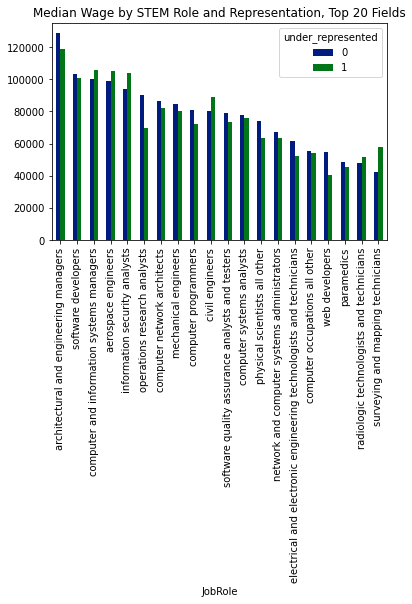

In [363]:
pd.crosstab(
    top_twenty_workers['JobRole'],
    top_twenty_workers['under_represented'],
    values=top_twenty_workers['INCWAGE'],
    aggfunc = 'median'
).sort_values(0,ascending=False).plot(
    kind='bar',
    title='Median Wage by STEM Role and Representation, Top 20 Fields'
)

#### In Total, What Portion of STEM Employees do not have a STEM Background?

In [364]:
df[df['stemType']!=-1]['is_STEM'].value_counts(normalize=True)

0    0.544062
1    0.455938
Name: is_STEM, dtype: float64

In [365]:
df[df['stemType']!=-1].groupby('under_represented')['is_STEM'].value_counts(normalize=True)

under_represented  is_STEM
0                  0          0.560221
                   1          0.439779
1                  1          0.503094
                   0          0.496906
Name: is_STEM, dtype: float64

In total, more than half of individuals working in a STEM field did not get a STEM education in both represented and unde-represented groups. We can also look at the top fields for this trend:

In [366]:
df_temp = df[df['stemType']!=-1]
temp_cross = pd.crosstab(
    df_temp['JobRole'],
    df_temp['is_STEM'],
)
temp_cross['n'] = temp_cross[0]+temp_cross[1]
temp_cross.sort_values(by='n',ascending=False)[:25]
#.plot(
#     kind='bar',
#     title='Median Wage by STEM Role and Representation, Top 20 Fields'
# )
# del df_temp

is_STEM,0,1,n
JobRole,,,
software developers,404,752,1156
computer occupations all other,462,150,612
computer and information systems managers,372,210,582
computer systems analysts,330,165,495
computer programmers,188,152,340
civil engineers,88,237,325
physical scientists all other,57,177,234
mechanical engineers,73,151,224
radiologic technologists and technicians,171,23,194


In [367]:
df[(df['JobRole'] == 'podiatrists') & (df['under_represented']==0)]

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,...,INCWAGE,State,under_represented,domestic_born,EDU_verbose,is_STEM,Degree,Degree_D,JobRole,stemType
3818,2020,2020,202003,5377475,2020000894061,46.35,2020053774753,42,80342,1,...,225000,Pennsylvania,0,1,PhD,1,Biology and Life Sciences,Biology,podiatrists,-1
20133,2020,2020,202003,5679586,2020000710577,28.84,2020056795863,47,270047,1,...,125000,Tennessee,0,1,PhD,1,Biology and Life Sciences,Biology,podiatrists,-1
21643,2020,2019,202003,2169572,2019000263357,31.93,2020021695723,17,341617,1,...,40499,Illinois,0,1,Master,1,Biology and Life Sciences,Biology,podiatrists,-1
46135,2020,2019,202003,4565748,2019000387890,33.99,2020045657483,37,120337,1,...,0,North Carolina,0,1,Master,1,Physical Sciences,Chemistry,podiatrists,-1
54134,2020,2020,202003,1033771,2020000905005,22.66,2020010337713,6,730506,1,...,310000,California,0,1,Master,0,Fine Arts,Music,podiatrists,-1
72068,2020,2019,202003,2191023,2019000862433,14.42,2020021910233,17,352417,1,...,52649,Illinois,0,1,Master,1,Biology and Life Sciences,Biology,podiatrists,-1
86727,2020,2019,202003,4849174,2019000840762,16.48,2020048491743,39,180539,1,...,0,Ohio,0,1,Master,1,Physical Sciences,Chemistry,podiatrists,-1
98988,2020,2019,202003,1873331,2019000583443,24.72,2020018733313,13,50013,1,...,131623,Georgia,0,1,Master,1,Medical and Health Sciences and Services,Nursing,podiatrists,-1
101274,2020,2020,202003,1043842,2020001013774,115.36,2020010438423,6,370806,1,...,10800,California,0,1,Master,1,Biology and Life Sciences,Zoology,podiatrists,-1
135028,2020,2019,202003,2873373,2019000671027,17.51,2020028733733,24,100124,1,...,227809,Maryland,0,1,Master,1,Biology and Life Sciences,Microbiology,podiatrists,-1
